In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
import medmnist
from medmnist.dataset import PneumoniaMNIST  # Dataset
from medmnist.dataset import OrganAMNIST, OrganCMNIST, OrganSMNIST
from medmnist import INFO, Evaluator


In [18]:
# data_flag = 'pneumoniamnist'
# data_flag = 'organamnist'
data_flag = 'organcmnist'
# data_flag = 'organsmnist'
download = True

num_epochs = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


In [4]:
# Do some preprocessing on the data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Split the Data
train_dataset = DataClass(
    split='train', transform=data_transform, download=download)
valid_dataset = DataClass(
    split='val',   transform=data_transform, download=download)
test_dataset = DataClass(
    split='test',  transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# Convert to DataLoader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,   shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=2*BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(
    dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/justinbull/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/justinbull/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/justinbull/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/justinbull/.medmnist/organcmnist.npz


In [5]:
print(train_dataset)
print("#########################################################################################################")
print(valid_dataset)
print("#########################################################################################################")
print(test_dataset)


Dataset OrganCMNIST (organcmnist)
    Number of datapoints: 13000
    Root location: /home/justinbull/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 13000, 'val': 2392, 'test': 8268}
    Description: The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1×28×28 to perform multi-

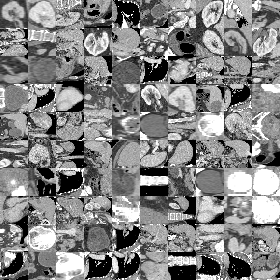

In [29]:
train_dataset.montage(length=10)


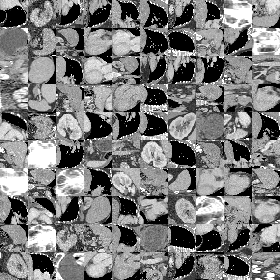

In [30]:
valid_dataset.montage(length=10)


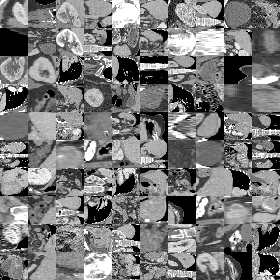

In [31]:
test_dataset.montage(length=10)


In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z


In [7]:
class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)


In [9]:
# Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)


Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=6, bias=True)
    (linear3): Linear(in_features=128, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [10]:
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Cuda
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() = vae.encoder.kl
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)


In [11]:
# Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():  # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() = vae.encoder.kl
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)


In [19]:
for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    print(
        f'\n EPOCH {epoch+1}/{num_epochs} \t train loss {train_loss:.3f} \t val loss {val_loss:.3f}')


	 partial train loss (single batch): 28046.810547
	 partial train loss (single batch): 26257.154297
	 partial train loss (single batch): 27120.386719
	 partial train loss (single batch): 24378.865234
	 partial train loss (single batch): 26182.832031
	 partial train loss (single batch): 26616.152344
	 partial train loss (single batch): 24692.320312
	 partial train loss (single batch): 24168.279297
	 partial train loss (single batch): 26649.863281
	 partial train loss (single batch): 24559.996094
	 partial train loss (single batch): 25420.203125
	 partial train loss (single batch): 27682.943359
	 partial train loss (single batch): 26026.761719
	 partial train loss (single batch): 26868.376953
	 partial train loss (single batch): 27447.357422
	 partial train loss (single batch): 25166.244141
	 partial train loss (single batch): 25677.794922
	 partial train loss (single batch): 25104.052734
	 partial train loss (single batch): 25388.089844
	 partial train loss (single batch): 25465.679688


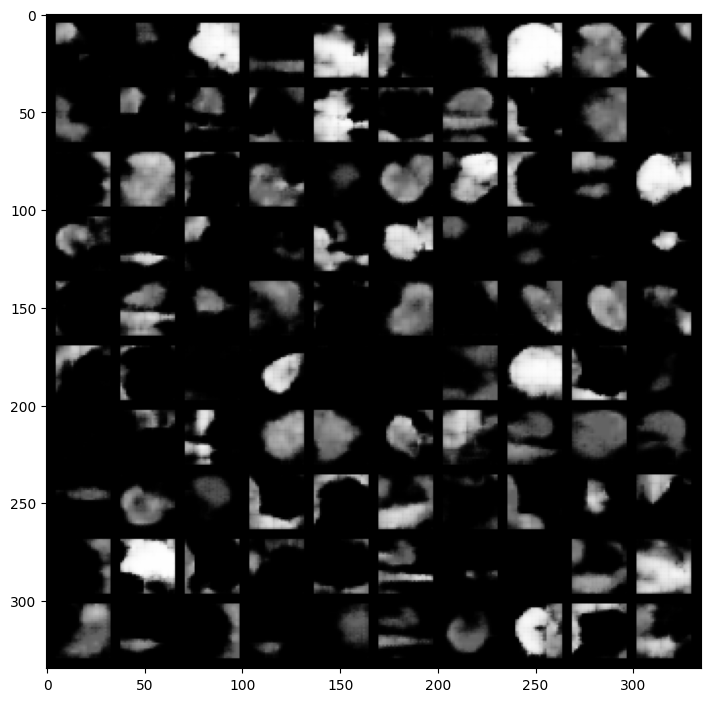

In [28]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()


In [22]:
import plotly.express as px
from sklearn.manifold import TSNE
from tqdm import tqdm

# Taken from example on Auto Encoders with regular MNist Data

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i,
                      enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)


100%|██████████| 8268/8268 [00:07<00:00, 1154.16it/s]


In [23]:
# Taken from SK Learn example on viewing multidimensional data

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(
    str), labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()
